In [6]:
import os
import pandas as pd
from pathlib import Path
import numpy as np
import plotnine as gg
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
topdir="Performance"
subdir='FEB_2021'
figures = "figures"
startdate="2021-02-01"
enddate="2021-02-28"


## Directories and Filepath

In [8]:
def paths(topdir, subdir, figures):
    
    folderpath = os.path.join(Path("../", topdir), subdir)

    figpath = os.path.join(folderpath, figures)


    def create_folder(path):
             
        if not os.path.exists(path):
        
            print ("directory is created")
        
            return os.makedirs(path)
    
        else:
            
            return print ("directory is already existed")

    
    
    folder = create_folder(folderpath)

    figdir = create_folder(figpath)
    
    return folderpath, figpath


folderpath, figpath = paths(topdir, subdir, figures)
print(folderpath)
print(figpath)

directory is already existed
directory is already existed
../Performance/FEB_2021
../Performance/FEB_2021/figures


In [9]:
csvpath = [os.path.join(folderpath, f) for f in os.listdir(folderpath)]

csvpath

['../Performance/FEB_2021/Apriso_FEB_2021.csv',
 '../Performance/FEB_2021/.DS_Store',
 '../Performance/FEB_2021/Tracker_FEB_2021.csv',
 '../Performance/FEB_2021/Repair_Department_Buffer_Report_FEB_2021.csv',
 '../Performance/FEB_2021/figures']

## Defining Paths

In [10]:
def csv_paths(folderpath):
    
    csvpath = [os.path.join(folderpath, f) for f in os.listdir(folderpath)]
    
    apriso_path = [f for f in csvpath if "Apriso" in f][0]
    
    tracker_path = [f for f in csvpath if "Tracker" in f][0]
    
    buffer_path = [f for f in csvpath if "Buffer" in f][0]
    
    return apriso_path, tracker_path, buffer_path


apriso_path, tracker_path, buffer_path = csv_paths(folderpath)

print(apriso_path)
print(tracker_path)
print(buffer_path)



../Performance/FEB_2021/Apriso_FEB_2021.csv
../Performance/FEB_2021/Tracker_FEB_2021.csv
../Performance/FEB_2021/Repair_Department_Buffer_Report_FEB_2021.csv


### Creating Merged dataframe which resulted after matching Tracker and Apriso Data

In [62]:
def create_merged_csv(apriso_path, tracker_path, figpath):
    
    tracker_columns = ['DATE','RBU_SN', 'FAIL_Category', 'Fail_Group', 
                       'TRSH_NAME','STATUS', 'Notes', 'REPAIR_Person',
                       'REPAIR_NOTES', 'PRE-TRSH_Person']

    dt_tracker = (pd.read_csv(tracker_path, engine='python')
                    .loc[:, tracker_columns]
                   )
    
    data_tracker = dt_tracker[dt_tracker['RBU_SN'].notnull()]
    
    
    apriso_columns = ['Serial #', 'Level 1', 'Level 2', 'Level 3', 'ProductNo']
    
    data_apriso = (pd.read_csv(apriso_path)
                   .loc[:, apriso_columns]
                  )


    data_apriso['RBU_SN'] = data_apriso[data_apriso.columns[0:4]].apply(
        lambda x: ''.join(x.dropna().astype(str)),
        axis=1
    )
    
    data_apriso = (data_apriso.loc[:, ['RBU_SN', 'ProductNo']])
    
    #data_tracker[data_tracker['DATE'].str.contains("\n\n")].replace("\n\n", " ")
    
    data_tracker['DATE'] = pd.to_datetime(data_tracker['DATE'], dayfirst = True,  errors='coerce')

    data_tracker['DATE'] = data_tracker['DATE'].astype(str)
    
    data_tracker = data_tracker.loc[(data_tracker['DATE'] >= startdate) & (data_tracker['DATE'] <= enddate)]
    
    merged = data_tracker.merge(data_apriso, how='left', left_on='RBU_SN', right_on= 'RBU_SN')

    merged = (merged
              .drop_duplicates()
              .drop(columns=['Fail_Group', 'Notes'], axis=1)
             )
              

        
    merged.loc[(merged['ProductNo'].str.contains("ROA1286713")) & (merged['FAIL_Category'] == 'RF'), 'FAIL_Category'] = "MBFT"
    

    
    pattren1 = '|'.join(["ea2a", " ea2a" , " EA2A"])
    
    pattren2 = '|'.join(["e23", " e23" , " E23"])
    
    merged['RBU_SN'] = merged['RBU_SN'].str.replace(pattren1, "EA2A")
    
    merged['RBU_SN'] = merged['RBU_SN'].str.replace(pattren2, "E23") 
        

    
    return merged

merged = create_merged_csv(apriso_path, tracker_path, figpath)

merged.head()

/Users/habbasi/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.


,DATE,RBU_SN,FAIL_Category,TRSH_NAME,STATUS,REPAIR_Person,REPAIR_NOTES,PRE-TRSH_Person,ProductNo
0,2021-02-01,EA2A118640,RF,Michael Smith U.,OTA,NaN,NaN,Scott N.,KRD901166/6
1,2021-02-01,EA2A141990,DIG,Maged Y.,PASS,NaN,NaN,Kazeem K.,NaN
2,2021-02-01,EA2A141896,DIG,Maged Y.,PASS,NaN,NaN,Scott N.,KRK10101/11
4,2021-02-01,EA2A134842,MBFT,Sujin K.,PASS,Rachel E.,Passive_Comp,NaN,ROA1286713/1
7,2021-02-01,EA2A143062,SMA_Repair,NaN,NaN,Daniel S.,Connector,NaN,ROA1286713/1


In [64]:
print(merged.REPAIR_Person.unique())
print(merged['PRE-TRSH_Person'].unique())

[nan 'Rachel E.' 'Daniel S.' 'Nelson L.' 'Khaliah T.' 'Tamela B.'
 'Thai L.' 'Tuan L.']
['Scott N.' 'Kazeem K.' nan 'Tri N.' 'Phat N.' 'Ve' 'Alton W.' 'Eric T.'
 'Luis G.' 'Tuan L.']


# Repair department

## Functions

This function is for renaming of Failure Categories for all departments

In [65]:

# def repair_dept_namechange(x):
    
#     if (x['FAIL_Category'] == 'RF') | (x['FAIL_Category'] == 'DIG'):
#         return "Radio"
    
#     elif (x['FAIL_Category'] == 'MBFT'):
#         return "MBFT"
    
#     elif (x['FAIL_Category'] == 'MVI'):
#         return "MVI"
    
#     elif (x['FAIL_Category'] == 'SMA_Repair') | (x['FAIL_Category'] == 'SMA_REPAIR'):
#         return "SMA_Repair"
    
#     elif (x['FAIL_Category'] == 'ICO_TRSH'):
#         return "ICO_TRSH"
    
#     elif (x['FAIL_Category'] ==  'Re-work_Order'):
#         return "Re-work_Order"
    
#     elif (x['FAIL_Category'] ==  "Mech"):
#         return "Mech"
    
#     elif (x['FAIL_Category'] == "Pre-Scrap"):
#         return "ROA Scrap"
    
#     elif ( x['FAIL_Category'] == "GU"):
#         return "Golden Units"
    
#     elif (x['FAIL_Category'] == 'VRT'):
#         return 'VRT'
    
    
    
    
TRSH_NAME=['Bo B.','Maged Y.','Matthew T.','Mekedes W.',
           'Michael Smith U.','Omar V.','Samuel T.',
           'Sujin K.','Yohannes A.']


REPAIR_NAME=['Daniel S.','Khaliah T.','Nelson L.',
             'Rachel E.','Tamela B.','Thai L.', 'Tri N.', 'Tuan L.']


PRETRSH_NAME=['Alton W.','Eric T.','Kazeem K.','Luis G.','Scott N.','Ve']


MVI_NAME=['Phat N.','Tri N.','Tuan L.']


Ist_shift = ['Bo B.','Maged Y.','Matthew T.','Michael Smith U.',
             'Sujin K.','Yohannes A.', 'Daniel S.','Khaliah T.',
             'Rachel E.', 'Alton W.','Kazeem K.','Scott N.', 
             'Phat N.','Tuan L.']


Sec_shift = ['Mekedes W.','Omar V.','Samuel T.','Nelson L.',
             'Tamela B.','Thai L.', 'Tri N.', 'Eric T.',
             'Luis G.','Ve']


   
# DAYS = len(merged['DATE'].unique())   ## No longer using


### Enter number of Days


DAYS = int(16)   
DAYS

16

In [66]:
merged['DATE'].unique()

array(['2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04',
       '2021-02-05', '2021-02-07', '2021-02-08', '2021-02-09',
       '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13',
       '2021-02-16', '2021-02-21', '2021-02-22', '2021-02-23',
       '2021-02-24', '2021-02-25', '2021-02-26', '2021-02-27',
       '2021-02-28'], dtype=object)

In [67]:
merged.columns

Index(['DATE', 'RBU_SN', 'FAIL_Category', 'TRSH_NAME', 'STATUS',
       'REPAIR_Person', 'REPAIR_NOTES', 'PRE-TRSH_Person', 'ProductNo'],
      dtype='object')

In [68]:

print(merged["TRSH_NAME"].unique())
print(merged["REPAIR_Person"].unique())
print(merged["PRE-TRSH_Person"].unique())




['Michael Smith U.' 'Maged Y.' 'Sujin K.' nan 'Samuel T.' 'Bo B.'
 'Yohannes A.' 'Omar V.' 'Mekedes W.']
[nan 'Rachel E.' 'Daniel S.' 'Nelson L.' 'Khaliah T.' 'Tamela B.'
 'Thai L.' 'Tuan L.']
['Scott N.' 'Kazeem K.' nan 'Tri N.' 'Phat N.' 'Ve' 'Alton W.' 'Eric T.'
 'Luis G.' 'Tuan L.']


## TRSH Performance and KPI

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/FEB_2021/figures/Trouble_shooters_performance_FEB_2021.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/FEB_2021/figures/Trouble_shooters_KPI.png


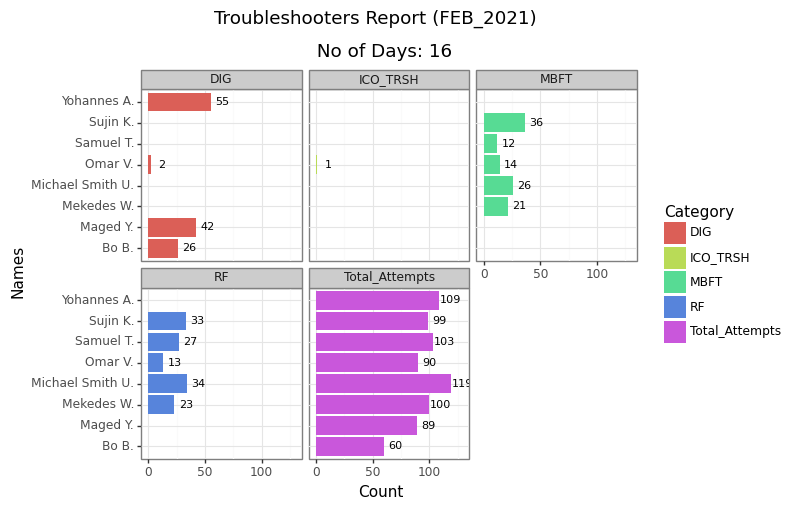

<ggplot: (7013966257)>


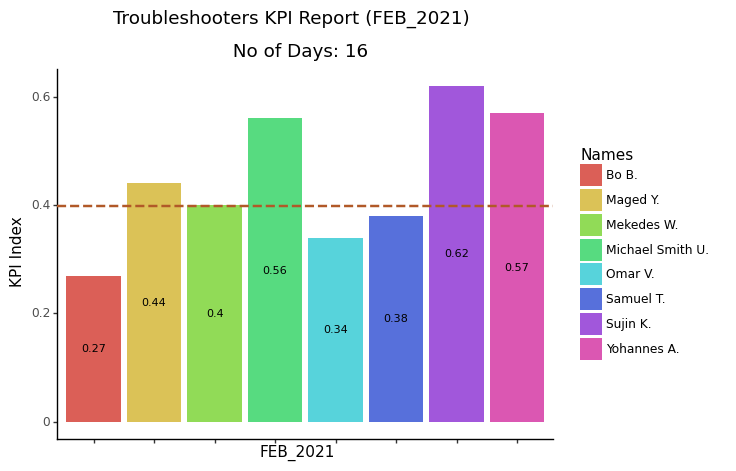

<ggplot: (7017943125)>


,Names,Category,Count
0,Bo B.,DIG,26
1,Maged Y.,DIG,42
2,Mekedes W.,MBFT,21
3,Mekedes W.,RF,23
4,Michael Smith U.,MBFT,26
5,Michael Smith U.,RF,34
6,Omar V.,DIG,2
7,Omar V.,ICO_TRSH,1
8,Omar V.,MBFT,14
9,Omar V.,RF,13


In [69]:
def TRSH_Performance_KPI(merged, TRSH_NAME, figpath, DAYS):
    
    tmp = merged.copy()
    

    def Failcategory_condition(x):
    
        if x["FAIL_Category"] == 'GU':
            return 'Golden Units'

        elif x["FAIL_Category"] == 'ICO_TRSH':
            return 'ICO_TRSH'

        elif x["FAIL_Category"] == 'Burn-In_Test':
            return 'Burn-In_Test'

        elif x["FAIL_Category"] == 'External_Claim':
            return 'External_Claim'
        
        else:
            return x['ProductNo']



    cat_condition=["DIG", "RF", "MBFT", "ICO_TRSH", "Golden Units", "Burn-In_Test", "External_Claim"]


    tmp['ProductNo'] = tmp.apply(Failcategory_condition, axis=1) # assigning ICO_TRSH in ProductNo column if FAIL_Category column contains "ICO_TRSH"

    tmp_df = (tmp.query('FAIL_Category in @ cat_condition and TRSH_NAME in @ TRSH_NAME')
                 .drop_duplicates(subset=["RBU_SN"], keep='last')  ## drop duplicate units and keeping the last row with unique unit
                 .dropna(subset=['ProductNo'])      ## droping na values based on ProductNo column
                 .groupby(['TRSH_NAME',"FAIL_Category"])
                 .count()
                 .reset_index()
                .loc[:, ['TRSH_NAME','FAIL_Category' ,'DATE']]
                .rename(columns={'TRSH_NAME': 'Names',
                                 'FAIL_Category': "Category",
                                 'DATE': "Count",
                                })

                )



    total = (merged.groupby('TRSH_NAME').count()
                .reset_index()
                .loc[:, ['TRSH_NAME','DATE']]
                .rename(columns={'TRSH_NAME': 'Names',
                                 'DATE': "Count",
                                })
                )


    total['Category'] = 'Total_Attempts'

    total = total.loc[:, ['Names', 'Category', 'Count']]

    fn = (tmp_df.append(total)
          .reset_index()
          .drop(columns='index')
         )

    p = gg.ggplot(fn, gg.aes(x='Names', y='Count',fill="Category", label='Count')) + \
        gg.geom_col(stat="identity") + \
        gg.theme_bw() + \
        gg.coord_flip() + \
        gg.geom_text(gg.aes(y = "Count",label = "Count"),  
                 size=8, nudge_x=0, nudge_y=10, show_legend=True) + \
        gg.labs(title= 'Troubleshooters Report' + ' (' + str(subdir) + ')  \n\n No of Days: ' + str(DAYS))



    p = p + gg.facet_wrap('~ Category', nrow=2)



    gg.ggsave(filename='Trouble_shooters_performance_' + str(subdir) +'.png', plot = p, path = figpath)


    ## Calculating TRSH KPI



    #min_threshold_radio=25
    target_radio= 6 * DAYS    ## 70 min / radio



    #min_threshold_board=25
    target_board= 8 * DAYS       ## 50 min / board



    def repair_dept_kpi(x):

        if (x['Category'] == 'RF') | (x['Category'] == 'DIG') | (x['Category'] == 'Golden Units') | (x['Category'] == 'Burn-In_Test') | (x['Category'] == 'External_Claim'):
            return "Radio"

        elif (x['Category'] == 'MBFT') | (x['Category'] == "ICO_TRSH"):
            return "Board"




    def KPI_radio(x):

        if (x['Category'] == "Radio") & (x['Names'] == 'Matthew T.'):

            k = (x['Count']) / (0.1 * target_radio)

            return k

        elif (x['Category'] == "Radio") & (x['Names'] == 'Omar V.'):

            k = (x['Count']) / (0.80 * target_radio)

            return k 

        elif (x['Category'] == "Radio"):

            k = (x['Count']) / (target_radio)

            return k 


    def KPI_board(x):

        if (x['Category'] == "Board") & (x['Names'] == 'Matthew T.'):

            k = (x['Count']) / (0.1 * target_board)

            return k 

        elif (x['Category'] == "Board") & (x['Names'] == 'Omar V.'):

            k = (x['Count'])  / (0.80 * target_board)

            return k 

        elif (x['Category'] == "Board"):

            k = (x['Count']) / (target_board)

            return k



    kpi = tmp_df.copy()



    kpi['Category'] = kpi.apply(repair_dept_kpi, axis=1)




    kpi = (kpi.groupby(["Names", "Category"])
               .sum()
               .reset_index()

              )



    kpi['KPI_Radio'] = kpi.apply(KPI_radio, axis=1)



    kpi['KPI_board'] = kpi.apply(KPI_board, axis=1)





    kpi = (kpi.groupby("Names")
               .sum()
               .reset_index()
               .assign(Total_Kpi = lambda x: np.round(x['KPI_Radio'] + x['KPI_board'], 2))
              )

    
    average = kpi['Total_Kpi'].sum()/ len(TRSH_NAME)

    g = gg.ggplot(kpi, gg.aes(x='Names', y='Total_Kpi',fill="Names", label='Total_Kpi')) + \
        gg.geom_col(stat="identity") + \
        gg.theme_classic() + \
        gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
        gg.geom_hline(yintercept = average,
                          color='#b15928',    
                          size=1,            
                          linetype="dashed") + \
        gg.labs(title= 'Troubleshooters KPI Report'+ ' (' + str(subdir) + ')  \n\n No of Days: ' + str(DAYS),
                x=str(subdir),
                y="KPI Index"
               ) + \
        gg.theme(axis_text_x=gg.element_blank())


    gg.ggsave(filename='Trouble_shooters_KPI.png', plot = g, path = figpath)


    return tmp_df, p, g



TRSH_data, TRSH_fig_1, TRSH_fig_2 = TRSH_Performance_KPI(merged, TRSH_NAME,figpath, DAYS)

print(TRSH_fig_1)
print(TRSH_fig_2)
      
TRSH_data

### Pre-TRSH performance and KPI

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/FEB_2021/figures/Pre_Trouble_shooters_performance_FEB_2021.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/FEB_2021/figures/Pre-Trouble_shooters_KPI_FEB_2021.png


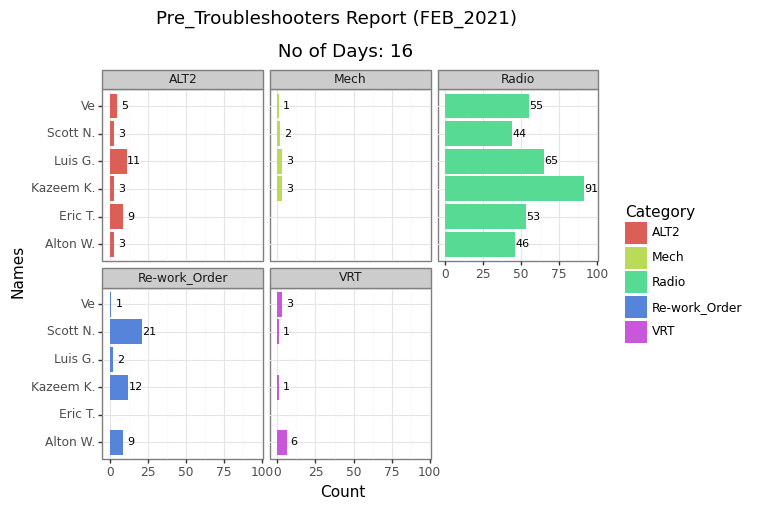

<ggplot: (7012934461)>


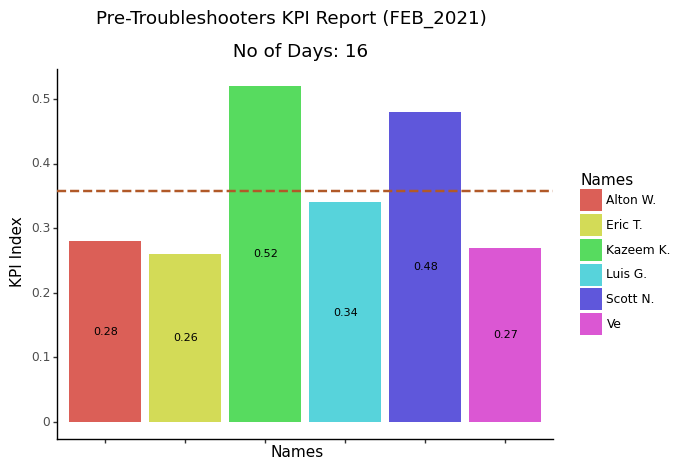

<ggplot: (7012956265)>


,Names,Category,Count
0,Alton W.,ALT2,3
1,Alton W.,Radio,46
2,Alton W.,Re-work_Order,9
3,Alton W.,VRT,6
4,Eric T.,ALT2,9
5,Eric T.,Radio,53
6,Kazeem K.,ALT2,3
7,Kazeem K.,Mech,3
8,Kazeem K.,Radio,91
9,Kazeem K.,Re-work_Order,12


In [70]:
def pre_TRSH_Performance_KPI(merged, figpath, PRETRSH_NAME, DAYS):
    
    
    def repair_dept_pre_TRSH(x):


        if (x['FAIL_Category'] == 'RF') | (x['FAIL_Category'] == 'DIG') | (x['FAIL_Category'] == 'Golden Units') | (x['FAIL_Category'] == 'Burn-In_Test') | (x['FAIL_Category'] == 'External_Claim'):
            return "Radio"

        elif (x['FAIL_Category'] ==  'Re-work_Order'):
            return "Re-work_Order"

        elif (x['FAIL_Category'] == "Mech") & (x['STATUS'] == "ALT2"):
            return "ALT2"

        elif (x['FAIL_Category'] == "Mech") & (x['STATUS'] != "ALT2"):
            return "Mech"

        elif (x['FAIL_Category'] == 'VRT'):
            return 'VRT'
        



        
# ## Calling RF and DIG. as Radio and count twice for similar person   
    

    tmp = merged.copy()


    tmp['Category'] = tmp.apply(repair_dept_pre_TRSH, axis=1)



    pre_TRSH_categories = ['Radio', 'VRT', 'ALT2', 'Re-work_Order',
           'Mech', "External_Claim", "Burn-In_Test", 'Golden Units']





    tmp = (tmp[tmp['Category'].isin(pre_TRSH_categories) &  
              tmp['PRE-TRSH_Person'].isin(PRETRSH_NAME)]
          )


    tmp1 = tmp.drop_duplicates(['RBU_SN', 'PRE-TRSH_Person', 'Category'], keep='last')




    
    pre_TRSH = (tmp1.groupby(['PRE-TRSH_Person','Category'])
            .count()
            .reset_index()
            .iloc[:, 0:3]
            .rename(columns={'PRE-TRSH_Person': 'Names',
                             'FAIL_Category':"Category",
                             'DATE': "Count"})

                  )




    pre = gg.ggplot(pre_TRSH, gg.aes(x='Names', y='Count',fill="Category", label='Count')) + \
            gg.geom_col(stat="identity") + \
            gg.theme_bw() + \
            gg.coord_flip() + \
            gg.geom_text(gg.aes(y = "Count",label = "Count"),  
                     size=8, nudge_x=0, nudge_y=5, show_legend=True) + \
            gg.labs(title= 'Pre_Troubleshooters Report' + ' (' + str(subdir) + ')  \n\n No of Days: ' + str(DAYS))



    pre = pre + gg.facet_wrap('~ Category', nrow=2)


    gg.ggsave(filename='Pre_Trouble_shooters_performance_' + str(subdir) +'.png', plot = pre, path = figpath)


    TRSH_KPI = (tmp1.groupby(['PRE-TRSH_Person','Category', 'ProductNo'])
            .count()
            .reset_index()
            .iloc[:, 0:4]
            .rename(columns={'PRE-TRSH_Person': 'Names',
                             'FAIL_Category':"Category",
                             'DATE': "Count"})

                  )



      # consider this is RAN compute product

    y  = 15 * DAYS  #(Radio=Mech.=Validation_test=65 min)

    target_Radio=15 * DAYS   ## 28 min / radio 
    target_Mech=15 * DAYS    ## 28 min / Mech.
    target_ALT2= 28 * DAYS    ## 15 min / ALT2
    target_Rework=8 * DAYS  ## 53 min / Rework
    target_VRT=15 * DAYS     ## 28 min / VRT
    target_Radio_RC=8* DAYS   ## 53 min / for radio mech. ALT, VRT for Ran compute




    def KPI_preTRSH(x):
         
        if x['ProductNo'] == "KRD901166/6":

            k = (x['Count']) / target_Radio_RC

            return k

        elif (x['ProductNo'] != "KRD901166/6") and  (x['Category'] == "Radio") | (x['Category'] == 'Mech') | (x['Category'] == 'VRT'):

            k = (x['Count']) / y

            return k

        elif (x['ProductNo'] != "KRD901166/6") and  x['Category'] == 'ALT2':

            k = (x['Count']) / target_ALT2

            return k

        elif (x['ProductNo'] != "KRD901166/6") and  x['Category'] == 'Re-work_Order':

            k = (x['Count']) / target_Rework

            return k    



    

   
    KPI_PTRSH = TRSH_KPI.copy()



    KPI_PTRSH['KPI_Pre-TRSH'] = KPI_PTRSH.apply(KPI_preTRSH, axis=1)
    
    
    def kpi_Scott(KPI_PTRSH):

        value = (KPI_PTRSH[KPI_PTRSH['Names'] == 'Scott N.']['KPI_Pre-TRSH']) / 0.8

        KPI_PTRSH.loc[(KPI_PTRSH["Names"]=='Scott N.'),'KPI_Pre-TRSH']= value

        return  KPI_PTRSH



    KPI_PTRSH = kpi_Scott(KPI_PTRSH)
    
    
    KPI_PTRSH = (KPI_PTRSH.groupby("Names")
           .sum()
           .reset_index()
           .loc[:, ['Names','Count', 'KPI_Pre-TRSH']]


          )



    KPI_PTRSH['KPI_Pre-TRSH'] = np.round(KPI_PTRSH['KPI_Pre-TRSH'], 2)
    
    average = KPI_PTRSH['KPI_Pre-TRSH'].sum()/ len(PRETRSH_NAME)


    g = gg.ggplot(KPI_PTRSH, gg.aes(x='Names', y='KPI_Pre-TRSH',fill="Names", label='KPI_Pre-TRSH')) + \
        gg.geom_col(stat="identity") + \
        gg.theme_classic() + \
        gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
        gg.geom_hline(yintercept = average,
                          color='#b15928',    
                          size=1,            
                          linetype="dashed") + \
        gg.labs(title= 'Pre-Troubleshooters KPI Report' + ' (' + str(subdir) + ')  \n\n No of Days: ' + str(DAYS) ,
                x='Names',
                y="KPI Index"
               ) + \
        gg.theme(axis_text_x=gg.element_blank())



    gg.ggsave(filename='Pre-Trouble_shooters_KPI_'+ str(subdir) + '.png', plot = g, path = figpath)
    
    

    return pre_TRSH, pre, g


pre_TRSH, pre_TRSH_fig_1, pre_TRSH_fig_2 = pre_TRSH_Performance_KPI(merged, figpath,PRETRSH_NAME, DAYS)  # RDpt_lg is used to generate repair department line graph


print(pre_TRSH_fig_1)
print(pre_TRSH_fig_2)

pre_TRSH
#tmp1.to_csv("test3.csv")

## MVI Performance and KPI

/Users/habbasi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/FEB_2021/figures/MVI_performance_modified_FEB_2021.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/FEB_2021/figures/KPI_MVI_FEB_2021.png


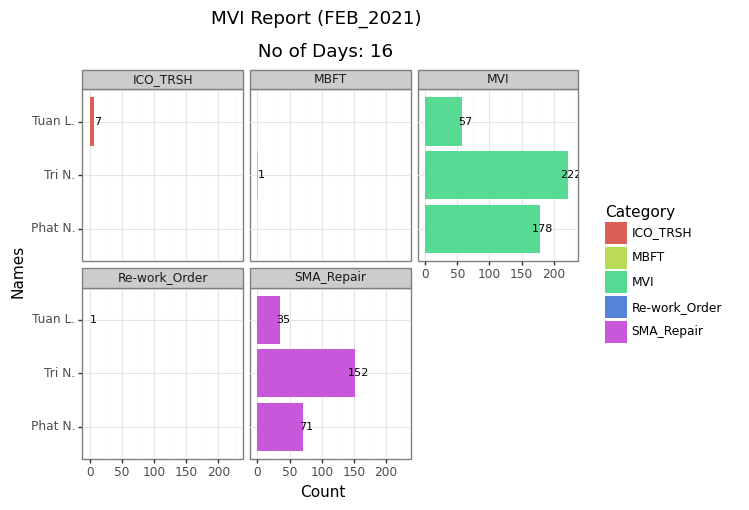

<ggplot: (7013048417)>


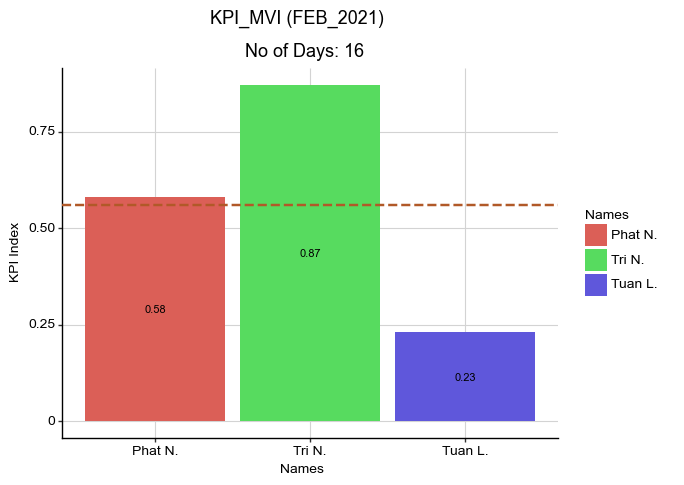

<ggplot: (7018408693)>


In [71]:
def MVI_Performance_KPI(merged, figpath, MVI_NAME, DAYS):
    
    
    def repair_dept_namechange(x):

        if (x['FAIL_Category'] == 'RF') | (x['FAIL_Category'] == 'DIG'):
            return "Radio"

        elif (x['FAIL_Category'] == 'MBFT'):
            return "MBFT"

        elif (x['FAIL_Category'] == 'MVI'):
            return "MVI"

        elif (x['FAIL_Category'] == 'SMA_Repair') | (x['FAIL_Category'] == 'SMA REPAIR'):
            return "SMA_Repair"

        elif (x['FAIL_Category'] == 'ICO_TRSH'):
            return "ICO_TRSH"

        elif (x['FAIL_Category'] ==  'Re-work_Order'):
            return "Re-work_Order"

        elif (x['FAIL_Category'] ==  "Mech"):
            return "Mech"

        elif (x['FAIL_Category'] == 'VRT'):
            return 'VRT'
        
        elif (x['FAIL_Category'] == "Pre-Scrap"):
            return "ROA Scrap"
    
        elif ( x['FAIL_Category'] == 'Golden Units'):
            return "Golden Units"
    
    


    mvi = merged[merged['PRE-TRSH_Person'].isin(MVI_NAME)]


    mvi['FAIL_Category'] = mvi.apply(repair_dept_namechange, axis=1)



    mvi = (mvi
           .drop_duplicates(['RBU_SN',"FAIL_Category",'PRE-TRSH_Person'], keep='last')
           .groupby(['PRE-TRSH_Person',"FAIL_Category"])
           .count()
           .reset_index()
           .loc[:, ['PRE-TRSH_Person','FAIL_Category', 'DATE']]
           .rename(columns={'PRE-TRSH_Person': 'Names',
                                   'FAIL_Category':"Category",
                                   'DATE': "Count"})

                 )


   
    mvi_plot = gg.ggplot(mvi, gg.aes(x='Names', y='Count',fill="Category", label='Count')) + \
                gg.geom_col(stat="identity") + \
                gg.theme_bw() + \
                gg.coord_flip() + \
                gg.geom_text(gg.aes(y = "Count",label = "Count"),  
                         size=8, nudge_x=0, nudge_y=5, show_legend=True) + \
                gg.labs(title= 'MVI Report' + ' (' + str(subdir) + ')  \n\n No of Days: ' + str(DAYS))



    mvi_plot= mvi_plot + gg.facet_wrap('~ Category', nrow=2)




    gg.ggsave(filename='MVI_performance_modified_'+ str(subdir) + '.png', plot = mvi_plot, path = figpath)
    
    
    
    
    #min_threshold_board_mvi=170
    
    target_board_mvi=27 * DAYS  # 12 min /board




    def mvi_kpi(x):

        if (x['Category'] == 'MVI') | (x['Category'] == 'SMA_Repair') | (x['Category'] == 'ICO_TRSH') | (x['Category'] == 'MBFT') | (x['Category'] == 'Re-work_Order'):
            return "board_mvi"



    def KPI_MVI(x):

        if (x['Category'] == "board_mvi"):

            k = (x['Count'])/ (target_board_mvi)

            return np.round(k, 2)


    
        
    KPI_mvi = mvi.copy()


    KPI_mvi['Category'] = KPI_mvi.apply(mvi_kpi, axis=1)
    

    


    KPI_mvi = (KPI_mvi.groupby(["Names", "Category"])
           .sum()
           .reset_index()

          )


    KPI_mvi['KPI_MVI'] = KPI_mvi.apply(KPI_MVI, axis=1)
    
    average = KPI_mvi['KPI_MVI'].sum()/ len(MVI_NAME)






    mvi_kpi = gg.ggplot(KPI_mvi, gg.aes(x='Names', y='KPI_MVI',fill="Names", label='KPI_MVI')) + \
        gg.geom_col(stat="identity") + \
        gg.theme_classic() + \
        gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
        gg.geom_hline(yintercept = average,
                          color='#b15928',    
                          size=1,            
                          linetype="dashed") + \
        gg.labs(title= 'KPI_MVI' + ' (' + str(subdir) + ')  \n\n No of Days: ' + str(DAYS),
                x='Names',
                y="KPI Index"
               ) + \
        gg.theme(
        axis_line=gg.element_line(size=1, colour="black"),
        panel_grid_major=gg.element_line(colour="#d3d3d3"),
        panel_grid_minor=gg.element_blank(),
        panel_border=gg.element_blank(),
        panel_background=gg.element_blank(),
        plot_title=gg.element_text(size=13, family="Arial"),
        text=gg.element_text(family="Arial", size=10),
        axis_text_x=gg.element_text(colour="black", size=10),
        axis_text_y=gg.element_text(colour="black", size=10)
    )




    gg.ggsave(filename='KPI_MVI_'+ str(subdir) + '.png', plot = mvi_kpi, path = figpath)
    
    return mvi, mvi_plot, mvi_kpi





mvi_data, mvi_fig1, mvi_fig2 = MVI_Performance_KPI(merged, figpath, MVI_NAME, DAYS)

print(mvi_fig1)
print(mvi_fig2)


## Soldering Performance and KPI

/Users/habbasi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/FEB_2021/figures/soldering_performanceFEB_2021.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/FEB_2021/figures/soldering_KPIFEB_2021.png


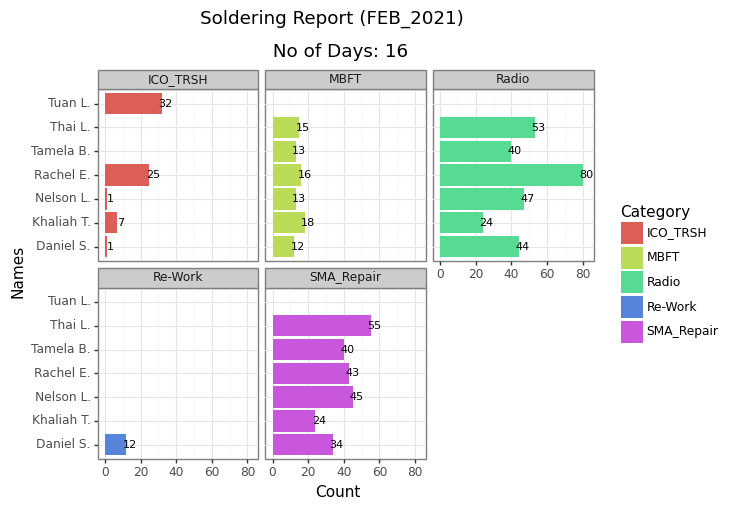

<ggplot: (7013247473)>


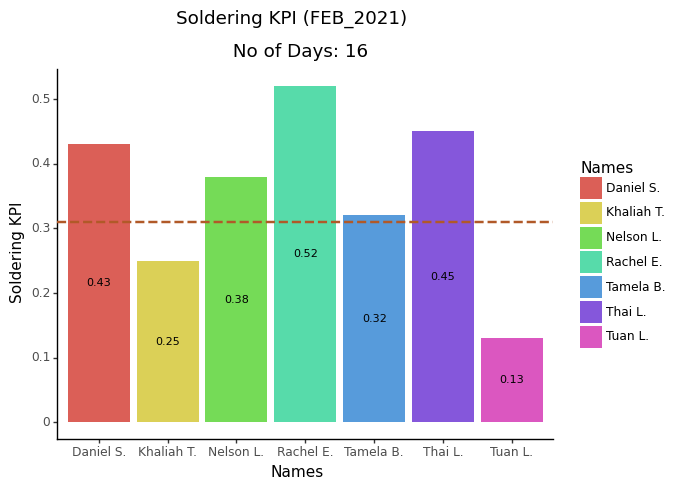

<ggplot: (7013213721)>


,Names,Category,Count
0,Daniel S.,ICO_TRSH,1
1,Khaliah T.,ICO_TRSH,7
2,Nelson L.,ICO_TRSH,1
3,Rachel E.,ICO_TRSH,25
4,Tuan L.,ICO_TRSH,32
5,Daniel S.,MBFT,12
6,Khaliah T.,MBFT,18
7,Nelson L.,MBFT,13
8,Rachel E.,MBFT,16
9,Tamela B.,MBFT,13


In [72]:
def soldering_Performance_KPI(merged, figpath, REPAIR_NAME, DAYS):
    
      
    def repairsoldering_dept_namechange(x):

        if (x['FAIL_Category'] == 'RF') | (x['FAIL_Category'] == 'DIG'):
            return "Radio"

        elif (x['FAIL_Category'] == 'SMA_Repair') | (x['FAIL_Category'] == 'SMA REPAIR'):
            return "SMA_Repair"

        elif (x['FAIL_Category'] == 'ICO_TRSH'):
            return "ICO_TRSH"

        elif (x['FAIL_Category'] ==  "MBFT"):
            return "MBFT"
        
        elif (x['FAIL_Category'] ==  "Re-work_Order"):
            return "Re-Work"
        
        elif (x['FAIL_Category'] == "Pre-Scrap"):
            return "ROA Scrap"


    repair = merged[merged['REPAIR_Person'].isin(REPAIR_NAME)]

    repair['FAIL_Category'] = (repair
                               .apply(repairsoldering_dept_namechange, axis=1)
                              )


    repair = (repair
              .drop_duplicates(['RBU_SN',"FAIL_Category",'REPAIR_Person', 'REPAIR_NOTES'], keep='last')
             )




    repair = (repair.groupby(['FAIL_Category','REPAIR_Person'])
              .count()
              .reset_index()
              .loc[:, ['FAIL_Category', 'REPAIR_Person','DATE']]
              .rename(columns={'REPAIR_Person': 'Names',
                                   'FAIL_Category':"Category",
                                   'DATE': "Count"})
              .loc[:, ['Names', 'Category', 'Count']]
              
             )



    soldering_plot = gg.ggplot(repair, gg.aes(x='Names', y='Count', fill="Category", label='Count')) + \
        gg.geom_bar(stat="identity") + \
        gg.theme_bw() + \
        gg.coord_flip() + \
        gg.geom_text(gg.aes(y = "Count",label = "Count"),  
                     size=8, nudge_x=0, nudge_y=2, show_legend=True) + \
        gg.labs(title= 'Soldering Report' + ' (' + str(subdir) + ')  \n\n No of Days: ' + str(DAYS))



    soldering_plot = soldering_plot + gg.facet_wrap('~ Category', nrow=2)






    gg.ggsave(filename='soldering_performance' + str(subdir) + '.png', plot = soldering_plot, path = figpath)


    # ## Calculating Soldering KPI



    soldering_categories=['Passive_Comp', '1_IC', '2_IC', 
                          'Connector', 'Pre-Scrap','3_IC']


    target_connector = 15 * DAYS     ## 28 min per connector / 1IC
    target_2_3IC = 7 * DAYS         ## 60 min per 2_IC or 3_IC
    target_1IC_Passive = 24 * DAYS   ## 18 min per manual soldering/hot air station for IC's or Passive Comp.


    def kpi_soldering(x):

        if x['Category'] == 'Connector':

            k = (x['Count']) / target_connector

            return k

        elif (x['Category'] == '2_IC') | (x['Category'] == '3_IC'):

            k = (x['Count']) / target_2_3IC

            return k


        elif (x['Category'] == '1_IC') | (x['Category'] == 'Passive_Comp'):

            k = (x['Count']) / target_1IC_Passive

            return k





    soldering_KPI = (merged
                     .groupby(['REPAIR_Person', 'REPAIR_NOTES'])
                     .count()
                     .reset_index()
                     .loc[:, ['REPAIR_Person', 'REPAIR_NOTES', 'DATE']]
                     .rename(columns={'REPAIR_Person': 'Names',
                                     'REPAIR_NOTES': 'Category',
                                     'DATE': 'Count'})
                     
                    )



    soldering_KPI['Soldering KPI'] = soldering_KPI.apply(kpi_soldering, axis=1)
    
    
        
    def kpi_TL(soldering_KPI):

        value = (soldering_KPI[soldering_KPI['Names'] == 'Daniel S.']['Soldering KPI']) / 0.8

        soldering_KPI.loc[(soldering_KPI["Names"]=='Daniel S.'),'Soldering KPI']= value

        return  soldering_KPI



    soldering_KPI = kpi_TL(soldering_KPI)

    soldering_KPI = (soldering_KPI.groupby('Names')
                    .sum()
                    .reset_index()
                    )



    soldering_KPI['Soldering KPI'] = np.round(soldering_KPI['Soldering KPI'], 2)

    average = soldering_KPI['Soldering KPI'].sum()/ len(REPAIR_NAME)

    soldering_kpi = gg.ggplot(soldering_KPI, gg.aes(x='Names', y='Soldering KPI', fill='Names', label='Soldering KPI')) + \
        gg.geom_bar(stat="identity") + \
        gg.theme_classic() + \
        gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
        gg.geom_hline(yintercept = average,
                          color='#b15928',    
                          size=1,            
                          linetype="dashed") + \
        gg.labs(title= 'Soldering KPI'+ ' (' + str(subdir) +')  \n\n No of Days: ' + str(DAYS))






    gg.ggsave(filename='soldering_KPI' + str(subdir) + '.png', plot = soldering_kpi, path = figpath)



    
    return repair, soldering_plot, soldering_kpi


repair_data, repair_fig1, repair_fig2 = soldering_Performance_KPI(merged, figpath, REPAIR_NAME, DAYS)

print(repair_fig1)
print(repair_fig2)


## Repair Department Report

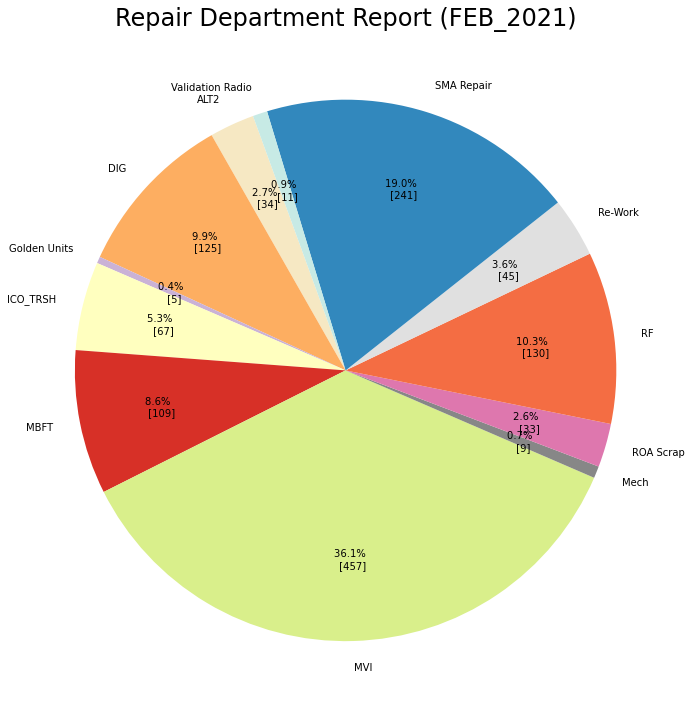

In [73]:

def repair_department_report(merged, TRSH_data, pre_TRSH, mvi_data, repair_data, figpath):
    
    
    golden = (merged.query('FAIL_Category == "GU"')
          .drop_duplicates("RBU_SN")
          .groupby("RBU_SN")
          .count()
          .reset_index()
          .iloc[:, 1:2]
          .rename(columns={'DATE': 'Count'})
 
                  )
    golden['Category'] = 'Golden Units'

    golden = golden.loc[:, ['Category', 'Count']]







    mvi_truncated = ['MVI', 'VRT']
    
    mvi_data = (mvi_data.query("Category in @ mvi_truncated")
                .iloc[:, 1:]
               )

    repair_truncated = ['ICO_TRSH', 'SMA_Repair']
    
    repair_data = repair_data.query('Category in @ repair_truncated').iloc[:, 1:]

#     repair_data = (repair_data.query("Category in @ repair_truncated")
#                    .iloc[:, 1:]
#                   )

    pre_TRSH_truncated = ['Mech','VRT', 'ALT2', 'Re-work_Order']

    pre_TRSH_data = (pre_TRSH.query("Category in @ pre_TRSH_truncated")
                   .iloc[:, 1:]
                  )

    TRSH_data = TRSH_data.iloc[:, 1:3]
    
    
    prescrap = (merged.query("STATUS == 'Pre-Scrap'")
            .drop_duplicates('RBU_SN', keep='last')
            .groupby('STATUS')
            .count()
            .reset_index()
            .iloc[:, 0:2]
            .rename(columns={'STATUS': 'Category',
                             'DATE': 'Count'})


           )


    
    final_data = (pd.concat([golden, TRSH_data, pre_TRSH_data, mvi_data, repair_data, prescrap])
              .groupby('Category')
              .sum()
              .reset_index()
              .groupby('Category')
              .sum()
              .reset_index()
              .replace(['Pre-Scrap', 'Re-work_Order', 'SMA_Repair', 'VRT'],
                       ['ROA Scrap', 'Re-Work', 'SMA Repair', 'Validation Radio'])
             )

 ## plotting pie chart
    
    
    plt.rcParams['font.size'] = 20


    labels = final_data['Category'].unique()

    values = final_data['Count'].values



    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(np.round(pct*total/100.0))
            return '{p:.1f}% \n [{v:d}]'.format(p=pct,v=val)
        return my_autopct


    mapping_colors = {'ALT2': '#f6e8c3',
                     'DIG': '#fdae61',
                     'ICO_TRSH': '#ffffbf',
                     'MBFT': '#d73027',
                     'MVI': '#d9ef8b',
                     'Mech': '#878787',
                     'RF': '#f46d43',
                     'ROA Scrap': '#de77ae',
                     'Re-Work': '#e0e0e0',
                     'SMA Repair': '#3288bd',
                     'Validation Radio': '#c7eae5',
                     'Golden Units': '#cab2d6'
                     }



    fig, ax = plt.subplots(figsize=(20, 10))
    ax.pie(values,labels=labels, colors = [mapping_colors[key] for key in labels], autopct=make_autopct(values),
            shadow=False, startangle=110, pctdistance=0.7, textprops={'color':"k", 
                                                                      'fontsize': 10}, 
           rotatelabels=False)


    # Equal aspect ratio ensures that pie is drawn as a circle

    plt.tight_layout()

    plt.title('Repair Department Report' + ' (' + str(subdir) + ')')


    plt.savefig(os.path.join(figpath, 'piechart_Repair Department Weekly report_' + str(subdir) +'.png'), bbox_inches='tight')          
  
    
    return ax


repair_department_report(merged, TRSH_data, pre_TRSH, mvi_data, repair_data, figpath)


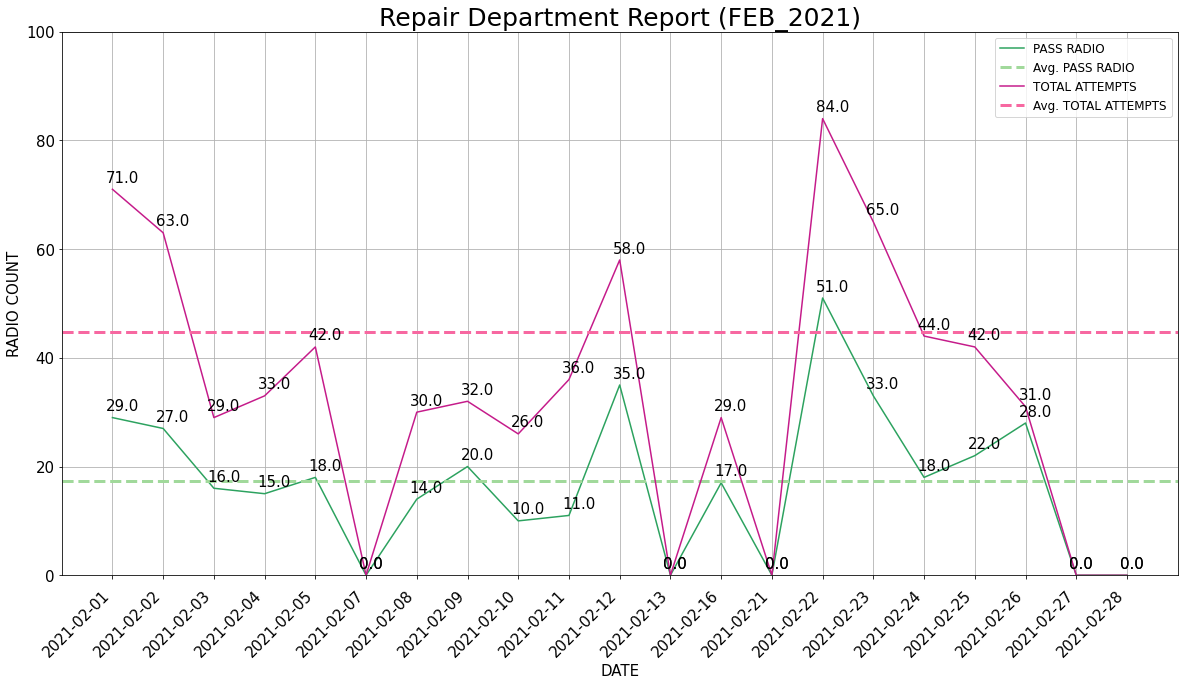

(<matplotlib.axes._subplots.AxesSubplot at 0x1a1f6e7110>,
     index        DATE  Count_Radio
 0       0  2021-02-01         29.0
 1       1  2021-02-02         27.0
 2       2  2021-02-03         16.0
 3       3  2021-02-04         15.0
 4       4  2021-02-05         18.0
 5      16  2021-02-07          0.0
 6       5  2021-02-08         14.0
 7       6  2021-02-09         20.0
 8       7  2021-02-10         10.0
 9       8  2021-02-11         11.0
 10      9  2021-02-12         35.0
 11     17  2021-02-13          0.0
 12     10  2021-02-16         17.0
 13     18  2021-02-21          0.0
 14     11  2021-02-22         51.0
 15     12  2021-02-23         33.0
 16     13  2021-02-24         18.0
 17     14  2021-02-25         22.0
 18     15  2021-02-26         28.0
 19     19  2021-02-27          0.0
 20     20  2021-02-28          0.0)

In [74]:
def radio_report(merged, figpath):
    
    
    tmp = merged.copy()
    




    radios=["RF", "DIG", 'Mech', 'GU','Re-work_Order']




    tmp = (tmp.query('FAIL_Category in @ radios')
                 .drop_duplicates(subset=["RBU_SN", "FAIL_Category"], keep='last')  ## drop duplicate units and keeping the last row with unique unit
                 .dropna(subset=['ProductNo'])      ## droping na values based on ProductNo column
                 .groupby('DATE')
                 .count()
                 .reset_index()
                .loc[:, ['DATE','RBU_SN']]
                .rename(columns={
                                 'RBU_SN': "Count_Radio",
                                })

                )


# tmp_df
    
#     tmp = (merged[merged['ProductNo'].str.contains('KRK*', na=False)]
#     .dropna(subset=['ProductNo']) 
#     .drop_duplicates(subset=["RBU_SN"], keep='last')
#     .groupby(['DATE',"FAIL_Category"])
#     .count()
#     .reset_index()
#     .groupby('DATE')
#     .sum()
#     .reset_index()
#     .loc[:, ['DATE','RBU_SN']]
#     .rename(columns={'RBU_SN': "Count_Radio"})

#    )




    tmp1 = (merged[merged['FAIL_Category'].isin(radios)]
            .groupby(['DATE','RBU_SN'])
            .count()
            .reset_index()
            .groupby('DATE')
            .sum()
            .reset_index()
            .loc[:, ['DATE','FAIL_Category']]
            .rename(columns={'FAIL_Category': "Count_Total"})

          )
    
    
    dates_mod = pd.DataFrame(merged['DATE'].unique().tolist(), columns=['DATE'])
    
    tmp = (tmp.merge(dates_mod, how='outer', on = 'DATE').fillna(value=0))
    
    tmp['DATE'] = pd.to_datetime(tmp['DATE'], dayfirst = True)
    
    tmp = tmp.sort_values(by='DATE',ascending=True).reset_index()
    
    
    tmp['DATE'] = tmp['DATE'].astype(str)
    
    
    average_tmp = np.average(tmp['Count_Radio'])

    average_tmp1 = np.average(tmp1['Count_Total'])
    
    
    tmp1 = tmp1.merge(dates_mod, how='outer', on = 'DATE')

    tmp1['DATE'] = pd.to_datetime(tmp1['DATE'], dayfirst = True)

    tmp1 = tmp1.sort_values(by='DATE',ascending=True).reset_index()

    tmp1['DATE'] = tmp1['DATE'].astype(str)

    tmp1 = tmp1.replace(np.nan, 0.0)




    from matplotlib.ticker import MaxNLocator
    plt.rcParams.update({'font.size': 15})



    fig, ax = plt.subplots(figsize=(20, 10))


    x = np.array(tmp['DATE'])
    y = np.array(tmp['Count_Radio'])

    y1 = np.array(tmp1['Count_Total'])

    values = list(tmp['Count_Radio'])
    values1 = list(tmp1['Count_Total'])

    plt.xlabel('DATE')
    plt.ylabel('RADIO COUNT')


    plt.title('Repair Department Report'+ ' (' + str(subdir) + ')', fontsize=25)

    ax.plot(x, y, color='#2ca25f', linestyle='solid', label='PASS RADIO')

    ax.axhline(average_tmp, color="#a1d99b", linestyle='dashed', linewidth=3)

    ax.plot(x, y1, color='#c51b8a', linestyle='solid', label='TOTAL ATTEMPTS')

    ax.axhline(average_tmp1, color="#f768a1", linestyle='dashed', linewidth=3)

    dates_label = merged.DATE.unique().tolist()

    ax.set_xticklabels(dates_label, rotation = 45, ha="right", position=(0,-0.01))



    for i, v in enumerate(values):
        plt.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')

    for i, v in enumerate(values1):
        plt.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')

    plt.ylim(0, 100)

    plt.legend(['PASS RADIO', 'Avg. PASS RADIO','TOTAL ATTEMPTS', 'Avg. TOTAL ATTEMPTS'], fontsize=12)

    plt.grid()
    plt.show()

    fig.savefig(os.path.join(figpath, "Repair_department_weekly_report_Radio_" + str(subdir) +'.png'))


    
    return ax, tmp

radio_report(merged, figpath)

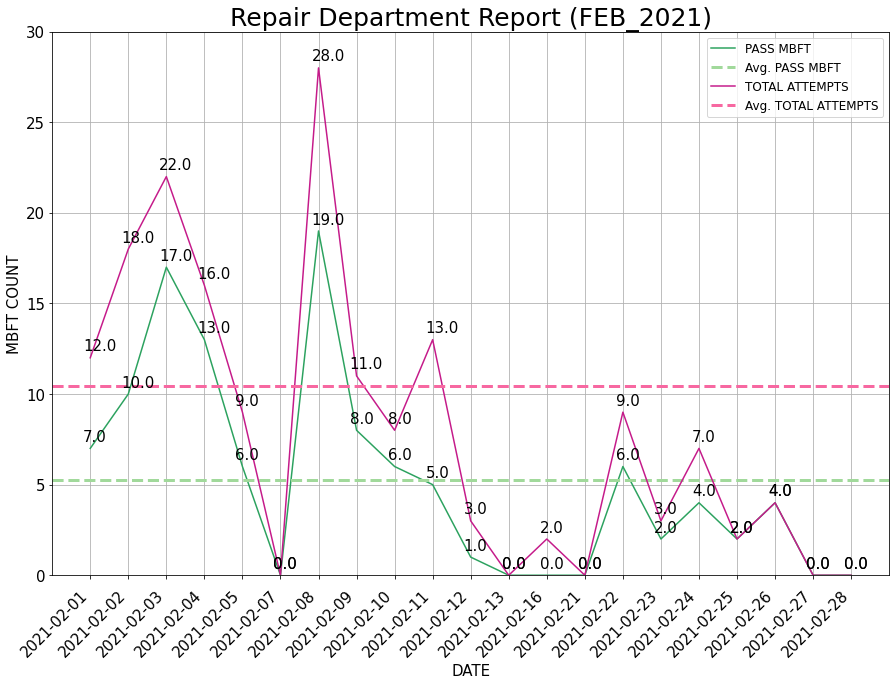

In [56]:
def mbft_report(merged, figpath):
    
    
    radios=['MBFT']
    
    
    tmp = (merged.query('FAIL_Category in @ radios')
             .drop_duplicates(subset=["RBU_SN"], keep='last')  ## drop duplicate units and keeping the last row with unique unit
             .dropna(subset=['ProductNo'])      ## Note: droping na values based on ProductNo column which means all the unit which couldn't pass are excluded
             .groupby(['DATE', "FAIL_Category"])
             .count()
             .reset_index()
             .loc[:, ['DATE','RBU_SN']]
             .rename(columns={'RBU_SN': 'Count'
                            })

            )




    tmp1 = (merged.query('FAIL_Category in @ radios')
            .groupby(['DATE','RBU_SN'])
            .count()
            .reset_index()
            .groupby('DATE')
            .sum()
            .reset_index()
            .loc[:, ['DATE','FAIL_Category']]
            .rename(columns={'FAIL_Category': "Count"})

          )
    
    """ Note: Here dates are taken for original merged file and merged with dataframe so that to get the 
    infomation of the on what days there were "NO" MBFT boards were passed"""
    


    dates_mod = pd.DataFrame(merged['DATE'].unique().tolist(), columns=['DATE'])

    tmp = (tmp.merge(dates_mod, how='outer', on = 'DATE').fillna(value=0))

    tmp['DATE'] = pd.to_datetime(tmp['DATE'], dayfirst = True)

    tmp = tmp.sort_values(by='DATE',ascending=True).reset_index()

    tmp['DATE'] = tmp['DATE'].astype(str)



    average_tmp = np.average(tmp['Count'])

    average_tmp1 = np.average(tmp1['Count'])




    tmp1 = tmp1.merge(dates_mod, how='outer', on = 'DATE')

    tmp1['DATE'] = pd.to_datetime(tmp1['DATE'], dayfirst = True)

    tmp1 = tmp1.sort_values(by='DATE',ascending=True).reset_index()

    tmp1['DATE'] = tmp1['DATE'].astype(str)

    tmp1 = tmp1.replace(np.nan, 0.0)



    from matplotlib.ticker import MaxNLocator

    plt.rcParams.update({'font.size': 15})
    #plt.rcParams["figure.figsize"] = [20,9]


    fig, ax = plt.subplots(figsize=(15, 10))

    #fig.yaxis.set_major_locator(MaxNLocator(integer=True))

    x = np.array(tmp['DATE'])
    y = np.array(tmp['Count'])

    y1 = np.array(tmp1['Count'])

    values = list(tmp1['Count'])
    values1 = list(tmp['Count'])

    plt.xlabel('DATE')
    plt.ylabel('MBFT COUNT')


    plt.title('Repair Department Report' + ' (' + str(subdir) + ')', fontsize=25)

    ax.plot(x, y, color='#2ca25f', linestyle='solid', label='PASS MBFT')
    ax.axhline(average_tmp, color="#a1d99b", linestyle='dashed', linewidth=3)

    ax.plot(x, y1, color='#c51b8a', linestyle='solid', label='TOTAL ATTEMPTS')

    ax.axhline(average_tmp1, color="#f768a1", linestyle='dashed', linewidth=3)
    
    dates_label = merged.DATE.unique().tolist()
    
    ax.set_xticklabels(dates_label, rotation = 45, ha="right", position=(0,-0.01))



    for i, v in enumerate(values):
        plt.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')

    for i, v in enumerate(values1):
        plt.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')

    plt.ylim(0, 30)

    plt.legend(['PASS MBFT', 'Avg. PASS MBFT','TOTAL ATTEMPTS', 'Avg. TOTAL ATTEMPTS'], fontsize=12)

    plt.grid()
    plt.show()


    fig.savefig(os.path.join(figpath, "Repair_department_weekly_report_MBFT_" + str(subdir) +'.png'))
    
    
    return ax

mbft_report(merged, figpath)
    

### Loading Data & Running function for creating buffer report

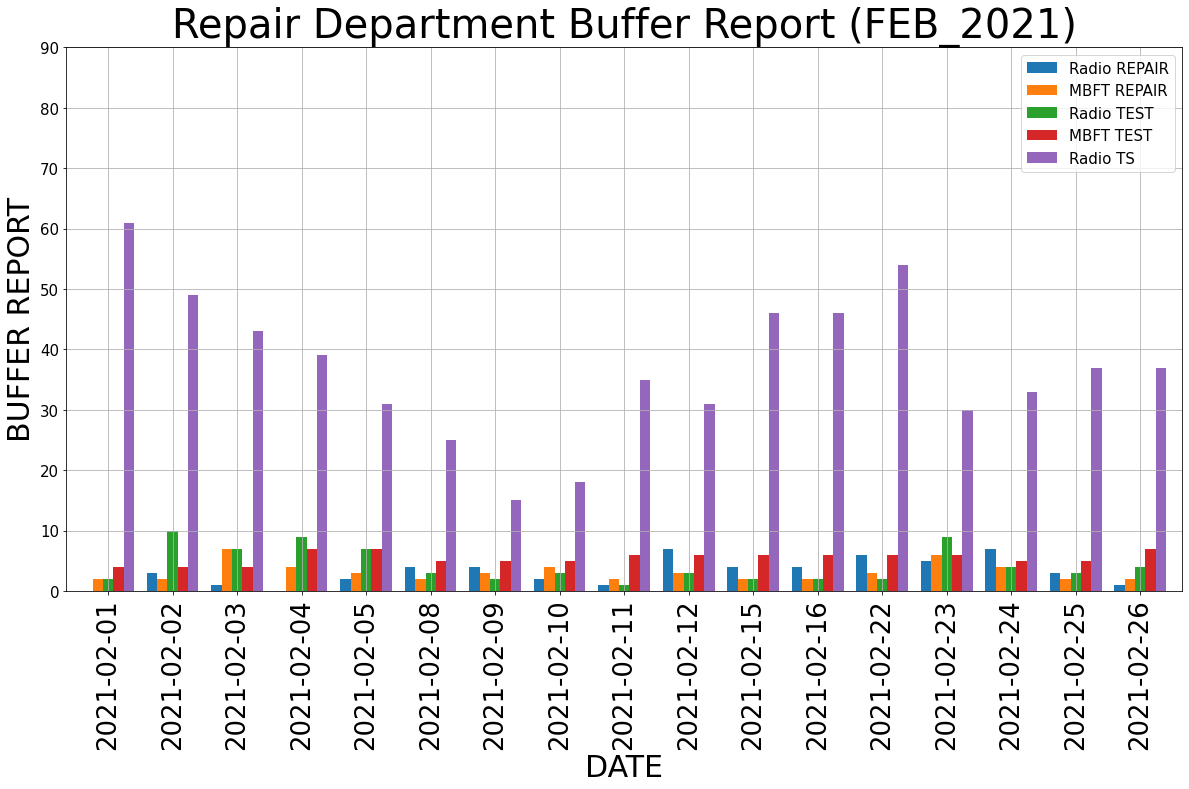

In [57]:
def buffer_figure(path, figpath):
    
    
    ''' path: path of data file
    
        figpath: path of saving figures
        
    '''
    data_buffer = pd.read_csv(path)
    
    data_buffer = data_buffer.dropna(how='all')
    
    
    ### Data preprocessing and converting DATE FORMAT and changed it string Format

    data_buffer['DATE'] = pd.to_datetime(data_buffer['DATE'], dayfirst = True)

    data_buffer['DATE'] = data_buffer['DATE'].astype(str)
    
    ### Plotting Figure
    
    
    plt.rcParams["figure.figsize"] = [20, 10]

    ax = data_buffer.plot.bar(x='DATE', y=list(data_buffer.columns[2:7]), width=0.8)

    plt.xlabel('DATE', fontsize=30)

    plt.ylabel('BUFFER REPORT', fontsize=30)

    ax.xaxis.set_tick_params(labelsize='xx-large')

    plt.title('Repair Department Buffer Report' + ' (' + str(subdir) + ')', fontsize=40)

    plt.legend(fontsize=15)

    plt.grid()

    plt.yticks(np.arange(0, 100, 10))

    plt.savefig(os.path.join(figpath, 'REPAIR DEPARTMENT BUFFER REPORT_' + str(subdir) +'.png'), bbox_inches='tight')
    
    
    return ax




buffer_figure(buffer_path, figpath)




## Repaired Products HC

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/FEB_2021/figures/Repaired_Products_HC_FEB_2021.png


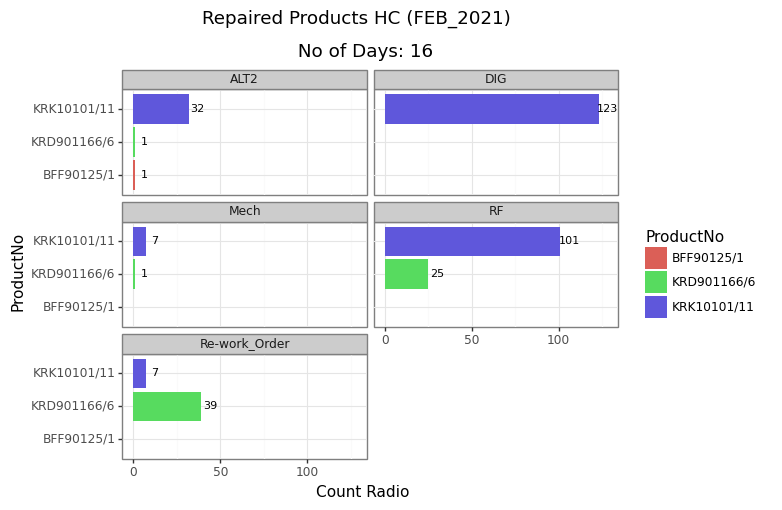

<ggplot: (7013540777)>

In [59]:
def RepairProductsHC(*args):
    
    
    def repair_dept_pre_TRSH(x):

        if (x['FAIL_Category'] == 'RF'):
            return "RF"

        elif (x['FAIL_Category'] == 'DIG'):
            return "DIG"

        elif (x['FAIL_Category'] ==  'Re-work_Order'):
            return "Re-work_Order"

        elif (x['FAIL_Category'] == "Mech") & (x['STATUS'] == "ALT2"):
            return "ALT2"

        elif (x['FAIL_Category'] == "Mech") & (x['STATUS'] != "ALT2"):
            return "Mech"


    tmp = merged.copy()

    tmp['Category'] = tmp.apply(repair_dept_pre_TRSH, axis=1)

    tmp= tmp[(tmp['ProductNo'].str.contains("^K")) | (tmp['ProductNo'].str.contains("^BFF"))]




    tmp = (tmp
                 .drop_duplicates(subset=["RBU_SN", "Category"], keep='last')
                 .dropna(subset=['ProductNo'])
                 .groupby(['DATE', 'Category', 'ProductNo'])
                 .count()
                 .reset_index()
                 .iloc[:, 0:4]
                 .rename(columns={
                                  'RBU_SN': "Count Radio",
                                })
                 .groupby(['Category', 'ProductNo'])
                 .sum()
                 .reset_index()


          )

    p = gg.ggplot(tmp, gg.aes(x='ProductNo', y='Count Radio',fill="ProductNo", label='Count Radio')) + \
                gg.geom_col(stat="identity") + \
                gg.theme_bw() + \
                gg.coord_flip() + \
                gg.geom_text(gg.aes(y = "Count Radio",label = "Count Radio"),  
                         size=8, nudge_x=0, nudge_y=5, show_legend=True) + \
                gg.labs(title= 'Repaired Products HC' + ' (' + str(subdir) + ')  \n\n No of Days: ' + str(DAYS))



    p = p + gg.facet_wrap('~ Category', nrow=3)


    gg.ggsave(filename='Repaired_Products_HC_' + str(subdir) +'.png', plot = p, path = figpath)






    return p


RepairProductsHC(*merged)

## Per Day Repaired Products HC

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/FEB_2021/figures/PerDay_Repaired_product_HCFEB_2021.png


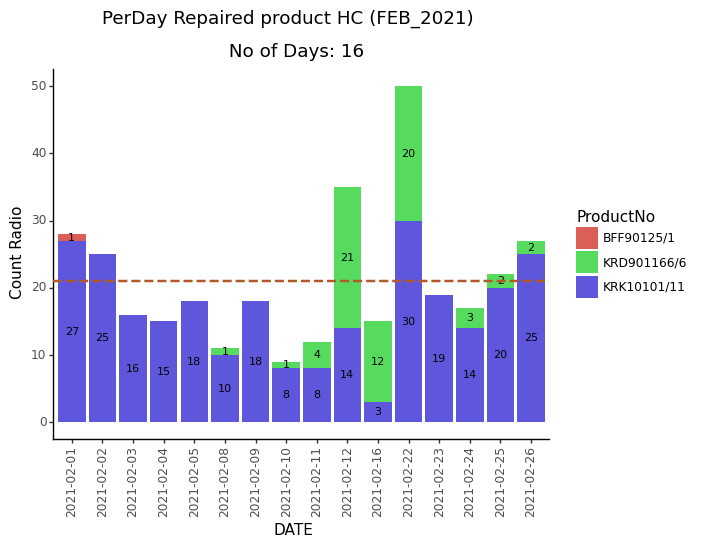

<ggplot: (7013002213)>

In [60]:
def PerDayRepairProductsHC(*args):
    
    def repair_dept_pre_TRSH(x):

        if (x['FAIL_Category'] == 'RF'):
            return "RF"

        elif (x['FAIL_Category'] == 'DIG'):
            return "DIG"

        elif (x['FAIL_Category'] ==  'Re-work_Order'):
            return "Re-work_Order"

        elif (x['FAIL_Category'] == "Mech") & (x['STATUS'] == "ALT2"):
            return "ALT2"

        elif (x['FAIL_Category'] == "Mech") & (x['STATUS'] != "ALT2"):
            return "Mech"


    tmp = merged.copy()

    tmp['Category'] = tmp.apply(repair_dept_pre_TRSH, axis=1)

    tmp= tmp[(tmp['ProductNo'].str.contains("^K")) | (tmp['ProductNo'].str.contains("^BFF"))]




    tmp1 = (tmp
                 .drop_duplicates(subset=["RBU_SN", "Category"], keep='last')
                 .dropna(subset=['ProductNo'])
                 .groupby(['DATE', 'Category', 'ProductNo'])
                 .count()
                 .reset_index()
                 .iloc[:, 0:4]
                 .rename(columns={
                                  'RBU_SN': "Count Radio",
                                })
                 .groupby(['DATE', 'ProductNo'])
                 .sum()
                 .reset_index()


          )
    
    average = tmp1["Count Radio"].sum()/len(tmp1.DATE.unique())
    
    




    p = gg.ggplot(tmp1, gg.aes(x='DATE', y='Count Radio', fill='ProductNo', label='Count Radio')) + \
        gg.geom_bar(stat="identity") + \
        gg.theme_classic() + \
        gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
        gg.geom_hline(yintercept = average,
                      color='#b15928',    
                      size=1,            
                      linetype="dashed") + \
        gg.labs(title= 'PerDay Repaired product HC'+ ' (' + str(subdir) +')  \n\n No of Days: ' + str(DAYS)) + \
        gg.theme(axis_text_x = gg.element_text(angle=90))
    
    gg.ggsave(filename='PerDay_Repaired_product_HC' + str(subdir) +'.png', plot = p, path = figpath)
    


    return p

PerDayRepairProductsHC(*merged)



## Per Day Unique Repaired Products HC

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: ../Performance/FEB_2021/figures/PerDay_Unique_Repaired_product_HCFEB_2021.png
/Users/habbasi/plotnine/plotnine/guides/guides.py:200: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
/Users/habbasi/plotnine/plotnine/guides/guides.py:200: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


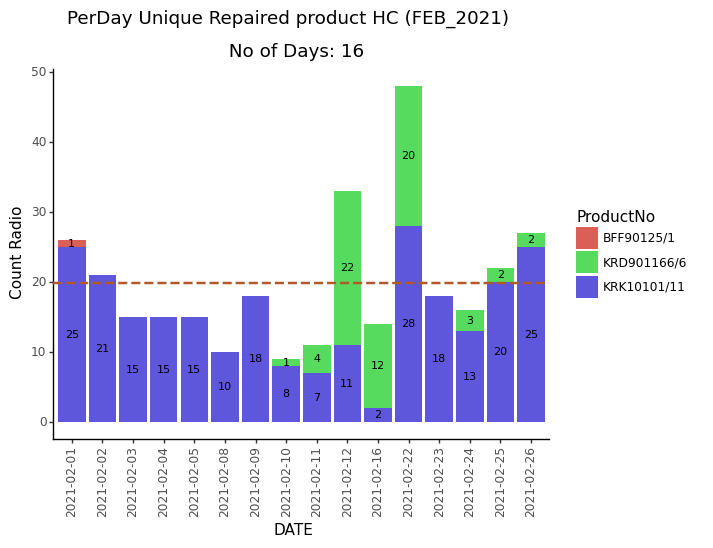

<ggplot: (7013170121)>

In [61]:
def PerDayUniqueRepairProductsHC(*args):

    tmp = merged.copy()

    tmp= tmp[(tmp['ProductNo'].str.contains("^K")) | (tmp['ProductNo'].str.contains("^BFF"))]



    tmp1 = (tmp
                 .drop_duplicates(subset=["RBU_SN", "ProductNo"], keep='last')
                 .dropna(subset=['ProductNo'])
                 .groupby(['DATE', 'ProductNo'])
                 .count()
                 .reset_index()
                 .iloc[:, 0:3]
                 .rename(columns={
                                  'RBU_SN': "Count Radio",
                                })


          )


    average = tmp1["Count Radio"].sum()/len(tmp1.DATE.unique())
    




    p = gg.ggplot(tmp1, gg.aes(x='DATE', y='Count Radio', fill='ProductNo', label='Count Radio')) + \
            gg.geom_bar(stat="identity") + \
            gg.theme_classic() + \
            gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
            gg.geom_hline(yintercept = average,
                          color='#b15928',    
                          size=1,            
                          linetype="dashed") + \
            gg.labs(title= 'PerDay Unique Repaired product HC'+ ' (' + str(subdir) +')  \n\n No of Days: ' + str(DAYS)) + \
            gg.theme(axis_text_x = gg.element_text(angle=90)) + \
            gg.scale_color_manual({'KRK10101/11':'#a6cee3', 
                                   'KRK10101/21':'#1f78b4', 
                                   'KRD901166/6': '#b2df8a',
                                   'BFF90125/1': '#33a02c',
                                  })

    gg.ggsave(filename='PerDay_Unique_Repaired_product_HC' + str(subdir) +'.png', plot = p, path = figpath)
    
    return p


PerDayUniqueRepairProductsHC(*merged)